In [1]:
print("Hello world")

Hello world


##### Download the data 

In [2]:
import os
import tarfile
import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    os.makedirs(housing_path, exist_ok=True)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

# call the function to downlaod and untar the .csv file
fetch_housing_data()


load the data

In [3]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

print first five row of data

In [4]:
housing = load_housing_data()
housing.head()
print(housing.shape)
print(housing.columns)
print(housing.describe())
# print(housing.info())

# count the value of ocean_proximity
housing["ocean_proximity"].value_counts()

(20640, 10)
Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity'],
      dtype='object')
          longitude      latitude  housing_median_age   total_rooms  \
count  20640.000000  20640.000000        20640.000000  20640.000000   
mean    -119.569704     35.631861           28.639486   2635.763081   
std        2.003532      2.135952           12.585558   2181.615252   
min     -124.350000     32.540000            1.000000      2.000000   
25%     -121.800000     33.930000           18.000000   1447.750000   
50%     -118.490000     34.260000           29.000000   2127.000000   
75%     -118.010000     37.710000           37.000000   3148.000000   
max     -114.310000     41.950000           52.000000  39320.000000   

       total_bedrooms    population    households  median_income  \
count    20433.000000  20640.000000  20640.000000   20640.000000   
me

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

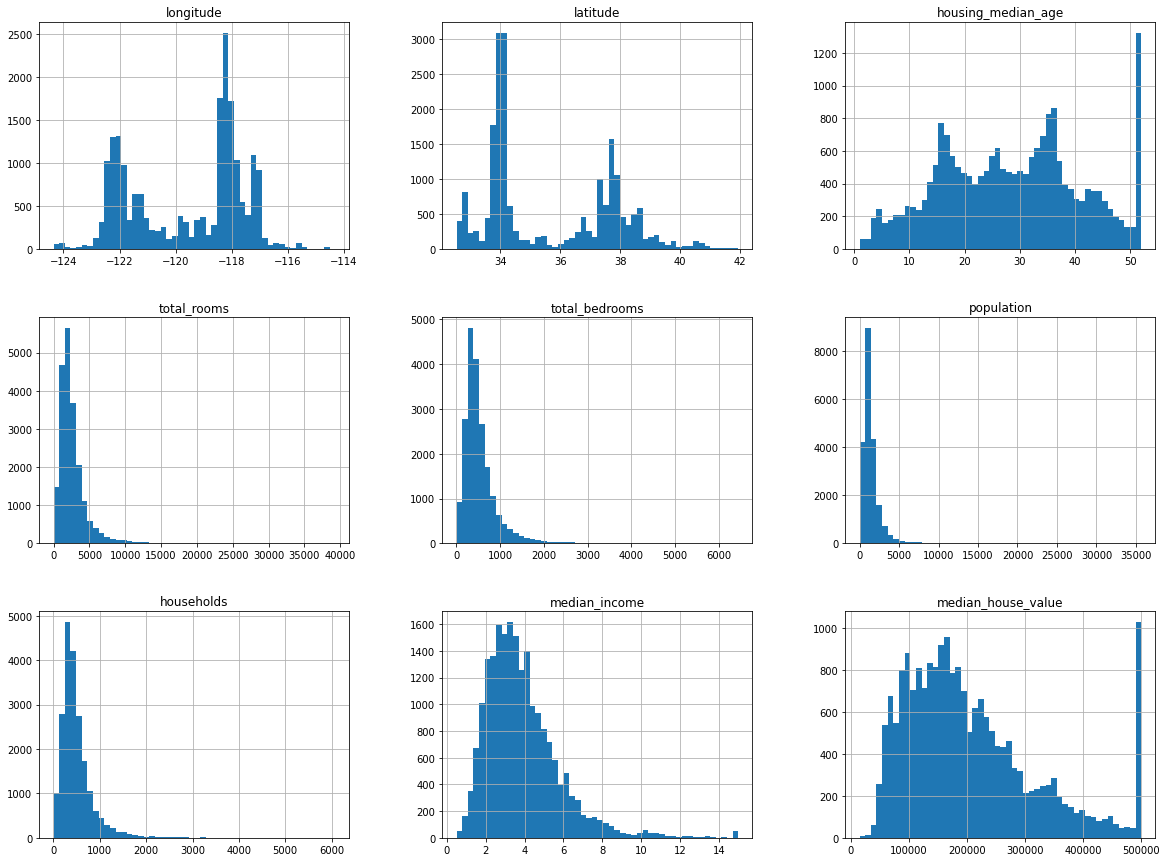

In [5]:
# Plot the histogram
%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20, 15))
plt.show()

##### Create test set

In [6]:
import numpy as np

def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [7]:
#use the split function to split the data
train_set, test_set = split_train_test(housing, 0.2)

In [8]:
print(len(train_set))
print(len(test_set))

16512
4128


In [9]:
#Check for hashing to split into train test split.
from zlib import crc32

def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

In [10]:
def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_ : test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]


In [11]:
housing_with_id = housing.reset_index()

train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, 'index')

In [12]:
print(len(train_set))
print(len(test_set))

16512
4128


In [13]:
#using train test split
from sklearn.model_selection import train_test_split

train_set , test_set = train_test_split(housing, test_size=0.20, random_state=42)

In [14]:
# got infromation from bussiness that the medium income important for predicting the housing price.
# lets create category for the income.
housing["income_cat"] = pd.cut(housing["median_income"], bins=[0., 1.5, 3.0, 4.5, 6.0, np.inf], labels=[1,2,3,4,5])

<AxesSubplot:>

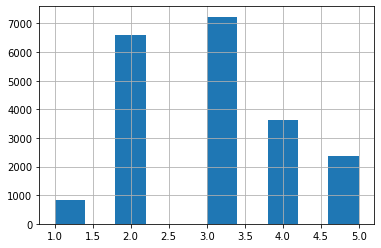

In [15]:
housing["income_cat"].hist()

In [16]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.20, random_state=42)
start_train_set = None
strat_test_set = None
for train_index, test_index in split.split(housing, housing["income_cat"]):
    start_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]



In [17]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: income_cat, dtype: float64

In [18]:
#drop the income_cat column
for set_ in (start_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

In [19]:
print(start_train_set.shape)
print(strat_test_set.shape)

(16512, 10)
(4128, 10)


#### Discover and Visualize the Data

In [20]:
housing_exp = start_train_set.copy()

visualizing the geographical Data

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

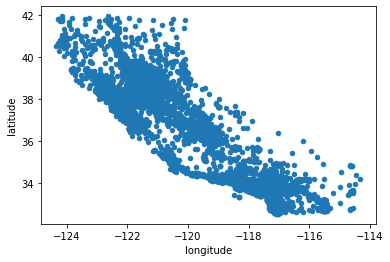

In [21]:
housing.plot(kind="scatter", x="longitude", y="latitude")

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

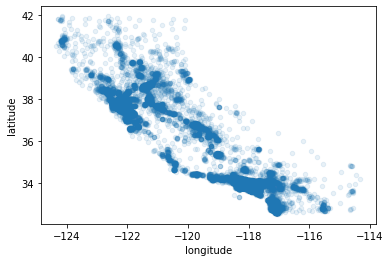

In [22]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)

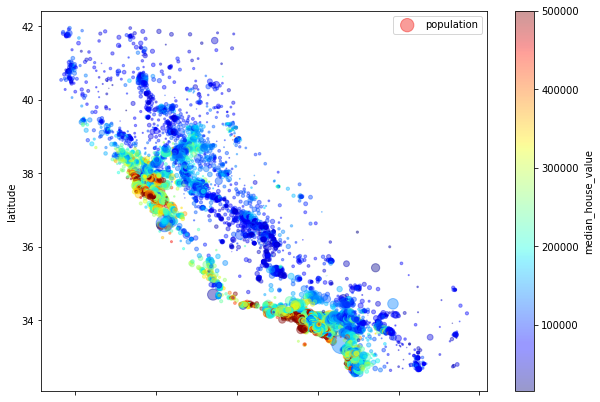

In [23]:
# plotting the circle radium as population, color as medium_house_value
housing.plot(
    kind="scatter",
    x="longitude",
    y="latitude",
    alpha=0.4,
    s=housing["population"]/100,
    label="population",
    figsize=(10, 7),
    c="median_house_value",
    cmap=plt.get_cmap("jet"),
    colorbar=True
)

plt.legend()

Looking for Correlation

In [24]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688075
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
population           -0.024650
longitude            -0.045967
latitude             -0.144160
Name: median_house_value, dtype: float64

In [25]:
print(corr_matrix)

                    longitude  latitude  housing_median_age  total_rooms  \
longitude            1.000000 -0.924664           -0.108197     0.044568   
latitude            -0.924664  1.000000            0.011173    -0.036100   
housing_median_age  -0.108197  0.011173            1.000000    -0.361262   
total_rooms          0.044568 -0.036100           -0.361262     1.000000   
total_bedrooms       0.069608 -0.066983           -0.320451     0.930380   
population           0.099773 -0.108785           -0.296244     0.857126   
households           0.055310 -0.071035           -0.302916     0.918484   
median_income       -0.015176 -0.079809           -0.119034     0.198050   
median_house_value  -0.045967 -0.144160            0.105623     0.134153   

                    total_bedrooms  population  households  median_income  \
longitude                 0.069608    0.099773    0.055310      -0.015176   
latitude                 -0.066983   -0.108785   -0.071035      -0.079809   
housing_

array([[<AxesSubplot:xlabel='median_house_value', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='median_income', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='median_house_value'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='median_income'>,
        <AxesSubplot:xlabel='median_income', ylabel='median_income'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='median_income'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='median_income'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='median_income', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='total_rooms'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='housing_median_age'>,
        <AxesSubplot:xlabel='median_incom

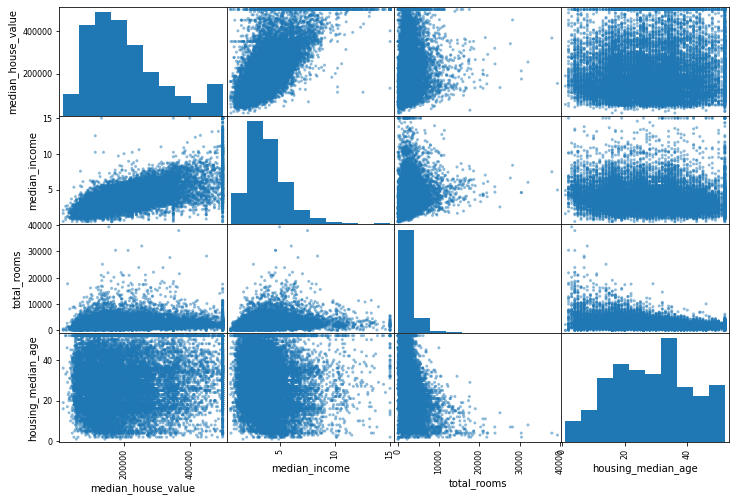

In [26]:
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]

scatter_matrix(housing_exp[attributes], figsize=(12, 8))

In [27]:
print(housing_exp.columns)

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity'],
      dtype='object')


<AxesSubplot:xlabel='median_income', ylabel='median_house_value'>

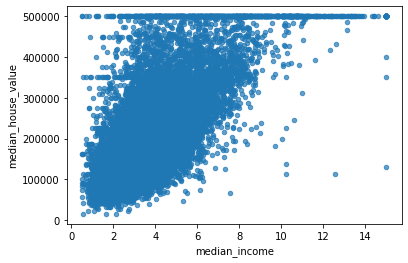

In [28]:
housing_exp.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.7)

In [29]:
print(housing_exp.columns)
print(housing_exp.head())

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity'],
      dtype='object')
       longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
12655    -121.46     38.52                29.0       3873.0           797.0   
15502    -117.23     33.09                 7.0       5320.0           855.0   
2908     -119.04     35.37                44.0       1618.0           310.0   
14053    -117.13     32.75                24.0       1877.0           519.0   
20496    -118.70     34.28                27.0       3536.0           646.0   

       population  households  median_income  median_house_value  \
12655      2237.0       706.0         2.1736             72100.0   
15502      2015.0       768.0         6.3373            279600.0   
2908        667.0       300.0         2.8750             82700.0   
14053       898.0       483.0         2.226

In [30]:
housing_exp.shape

(16512, 10)

In [31]:
housing_exp["room_per_household"] = housing_exp["total_rooms"]/ housing_exp["households"]
housing_exp["bedrooms_per_room"] = housing_exp["total_bedrooms"] / housing_exp["total_rooms"]
housing_exp["population_per_household"] = housing_exp["population"] / housing_exp["households"]

In [32]:
housing_exp.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,room_per_household,bedrooms_per_room,population_per_household
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736,72100.0,INLAND,5.485836,0.205784,3.168555
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373,279600.0,NEAR OCEAN,6.927083,0.160714,2.623698
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.8750,82700.0,INLAND,5.393333,0.191595,2.223333
14053,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264,112500.0,NEAR OCEAN,3.886128,0.276505,1.859213
20496,-118.70,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964,238300.0,<1H OCEAN,6.096552,0.182692,3.167241


In [33]:
corr_matrix_new = housing_exp.corr()
print(corr_matrix_new)

                          longitude  latitude  housing_median_age  \
longitude                  1.000000 -0.924478           -0.105823   
latitude                  -0.924478  1.000000            0.005737   
housing_median_age        -0.105823  0.005737            1.000000   
total_rooms                0.048909 -0.039245           -0.364535   
total_bedrooms             0.076686 -0.072550           -0.325101   
population                 0.108071 -0.115290           -0.298737   
households                 0.063146 -0.077765           -0.306473   
median_income             -0.019615 -0.075146           -0.111315   
median_house_value        -0.047466 -0.142673            0.114146   
room_per_household        -0.028374  0.107665           -0.147184   
bedrooms_per_room          0.095645 -0.116955            0.136768   
population_per_household  -0.000415  0.005426            0.015031   

                          total_rooms  total_bedrooms  population  households  \
longitude            

In [34]:
.corr_matrix_new["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687151
room_per_household          0.146255
total_rooms                 0.135140
housing_median_age          0.114146
households                  0.064590
total_bedrooms              0.047781
population_per_household   -0.021991
population                 -0.026882
longitude                  -0.047466
latitude                   -0.142673
bedrooms_per_room          -0.259952
Name: median_house_value, dtype: float64

##### Prepare data for machine learning algorithm

In [36]:
housing_2 = start_train_set.drop("median_house_value", axis=1)
housing_2_label = start_train_set["median_house_value"].copy()

In [39]:
print(housing_2.shape)
print(housing_2_label.shape)

(16512, 9)
(16512,)


Data cleaning

In [40]:
# fill na value in bedroom columns
median = housing_2["total_bedrooms"].median()
housing["total_bedrooms"].fillna(median, inplace=True)

In [41]:
# or use inbuild imputer to fill median value of each attribute.
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")

# imputer cannot apply on the object data. so lets drop the ocean_proximity which type is object.
housing_2_num = housing_2.drop("ocean_proximity", axis=1)

imputer.fit(housing_2_num)


SimpleImputer(strategy='median')

In [44]:
print(imputer.statistics_)
print(housing_2_num.median().values)

[-118.51      34.26      29.      2119.       433.      1164.
  408.         3.54155]
[-118.51      34.26      29.      2119.       433.      1164.
  408.         3.54155]


In [45]:
#transform the training data
X = imputer.transform(housing_2_num)

In [50]:
# transform the numpy array to panda dataframe
housing_2_tr = pd.DataFrame(X, columns=housing_2_num.columns, index=housing_2_num.index)

In [52]:
print(housing_2_tr.head())

       longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
12655    -121.46     38.52                29.0       3873.0           797.0   
15502    -117.23     33.09                 7.0       5320.0           855.0   
2908     -119.04     35.37                44.0       1618.0           310.0   
14053    -117.13     32.75                24.0       1877.0           519.0   
20496    -118.70     34.28                27.0       3536.0           646.0   

       population  households  median_income  
12655      2237.0       706.0         2.1736  
15502      2015.0       768.0         6.3373  
2908        667.0       300.0         2.8750  
14053       898.0       483.0         2.2264  
20496      1837.0       580.0         4.4964  


In [54]:
print(imputer.strategy)
print(imputer.statistics_)


median
[-118.51      34.26      29.      2119.       433.      1164.
  408.         3.54155]


In [60]:
housing_2_cat = housing_2[["ocean_proximity"]]
print(housing_2_cat.head(10))

# create find ocean proximity median repeated value
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_2_cat)
housing_cat_encoded[:10]


      ocean_proximity
12655          INLAND
15502      NEAR OCEAN
2908           INLAND
14053      NEAR OCEAN
20496       <1H OCEAN
1481         NEAR BAY
18125       <1H OCEAN
5830        <1H OCEAN
17989       <1H OCEAN
4861        <1H OCEAN


array([[1.],
       [4.],
       [1.],
       [4.],
       [0.],
       [3.],
       [0.],
       [0.],
       [0.],
       [0.]])

In [62]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [70]:
# Create the one hot encoding for the category attribute "ocean_proximity"

from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_2_cat)
print(housing_cat_1hot.toarray())
print(cat_encoder.categories_)

[[0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 ...
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]]
[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
      dtype=object)]


Custome transformers

In [72]:
from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, households_ix = 3,4,5,6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): 
        self.add_bedrooms_per_room = add_bedrooms_per_room
    
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

In [77]:
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_2_extra_attributes = attr_adder.transform(housing_2.values)

print(housing_2_extra_attributes.shape)


(16512, 11)


##### Feature Scaling